In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.optimizers import *
import os
from random import uniform
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generating input sequence

**NARMA-1 task**: $$ y_k = 0.3y_{k-1} + 0.05y_{k-1}^2 + 1.5u_k^2+0.1$$

In [4]:
seq_length = 300

In [5]:
def next_value(prev, u):
    return 0.3*prev + 0.05* (prev**2) + 1.5*(u**2)+0.1    

In [6]:
def generate():
    sequence = [0.5]
    input = [0]
    for i in range(seq_length-1):
        u = uniform (0, 0.5)
        input.append(u)
        sequence.append(next_value(sequence[-1], u))
    return (np.array(input), np.array(sequence))


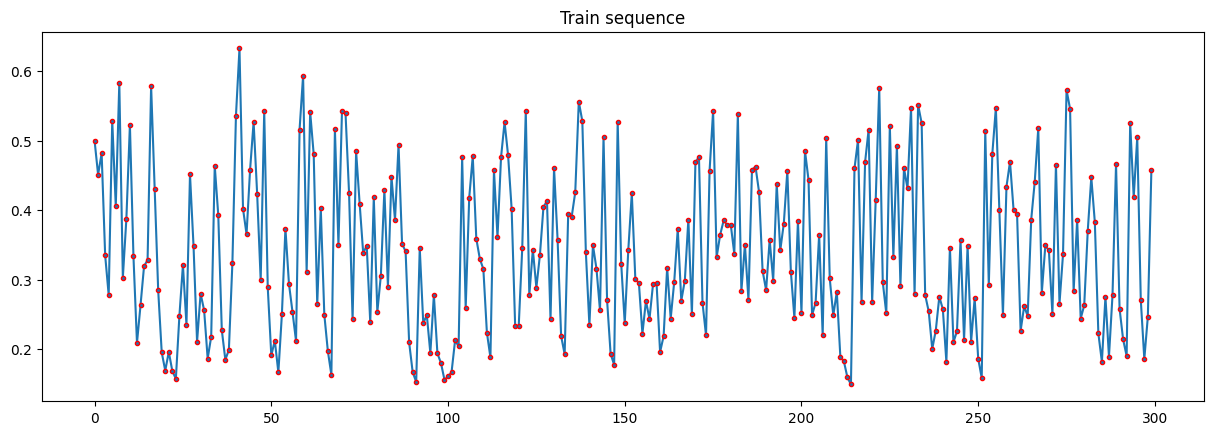

In [7]:
train_input, train_target = generate()
plt.figure().set_figwidth(15)
plt.plot(train_target, marker = '.', markeredgecolor = 'r')
plt.title("Train sequence")
plt.show()

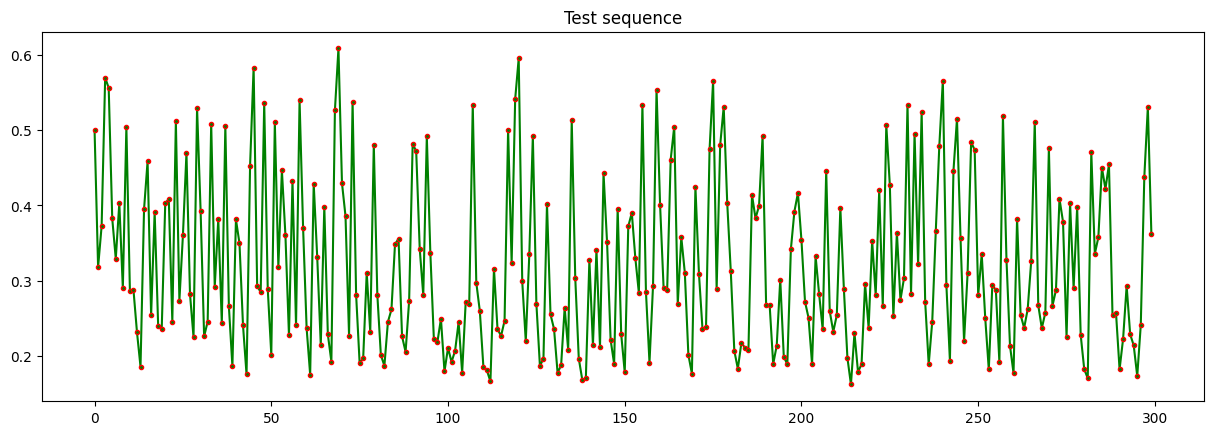

In [9]:
test_input, test_target = np.array(generate())
plt.figure().set_figwidth(15)
plt.plot(test_target, marker = '.', color = 'g',markeredgecolor = 'r')
plt.title("Test sequence")
plt.show()

## MEMS Computation

In [10]:
mems_input = np.transpose(np.stack((train_input, test_input), axis = 1))

In [31]:
# Constants
sine_freq = 115e3
sine_amp = 1.0
num_features = 300
separation_time = 1/sine_freq
endTime = separation_time*num_features
a = 70
b = 2.088e12
c = 2.9e26
alpha = 4614
total_samples = 1000*num_features
num_examples = 2

# Initial conditions
x0 = 0.0
v0 = 0.0
initial_state = [x0, v0]

time_points = np.linspace(0, num_features * separation_time, num_features * 1000)
sine_wave = sine_amp * np.sin(2 * np.pi * sine_freq * time_points)
mask_values = np.asarray([0.70, 0.45, 0.45, 0.70, 0.70])
mask_d = np.tile(mask_values, (300, 1))
mask_c = np.repeat(mask_d, 1000/5)

In [94]:
def F(t):
    return alpha * (0.4*masked_input[(int((t/(separation_time*num_features)) * total_samples))%total_samples])**2

In [95]:
def ODE(xv, t, a, b, c, alpha):
    x, v = xv
    dxdt = v
    dvdt = -a*v - b*x - c*x**3 + F(t)
    return [dxdt, dvdt]

In [194]:
outputs = np.zeros((2, 1500))
curr = 0
batch_size = 1
for idx in range(2):
    sample_input = mems_input[idx, :]
    modulation = sample_input * 0.15 + 0.6
    modulation_c = np.repeat(modulation, 1000)
    modulated_input = modulation_c*sine_wave
    masked_input = modulated_input * mask_c
    result = np.array(odeint(ODE, initial_state, time_points, args = (a, b, c, alpha))[:, 0])  
    outputs[idx, :] = [result[i] for i in range(total_samples) if i%200 == 0]
    curr = curr+1
    print(f"Solved {idx+1}/{num_examples}")
print("Saving checkpoint to CSV...")
df = pd.DataFrame(outputs)
## df.to_csv("mems_outputs_py_1.csv", index = None) 

Solved 1/2
Solved 2/2
Saving checkpoint to CSV...


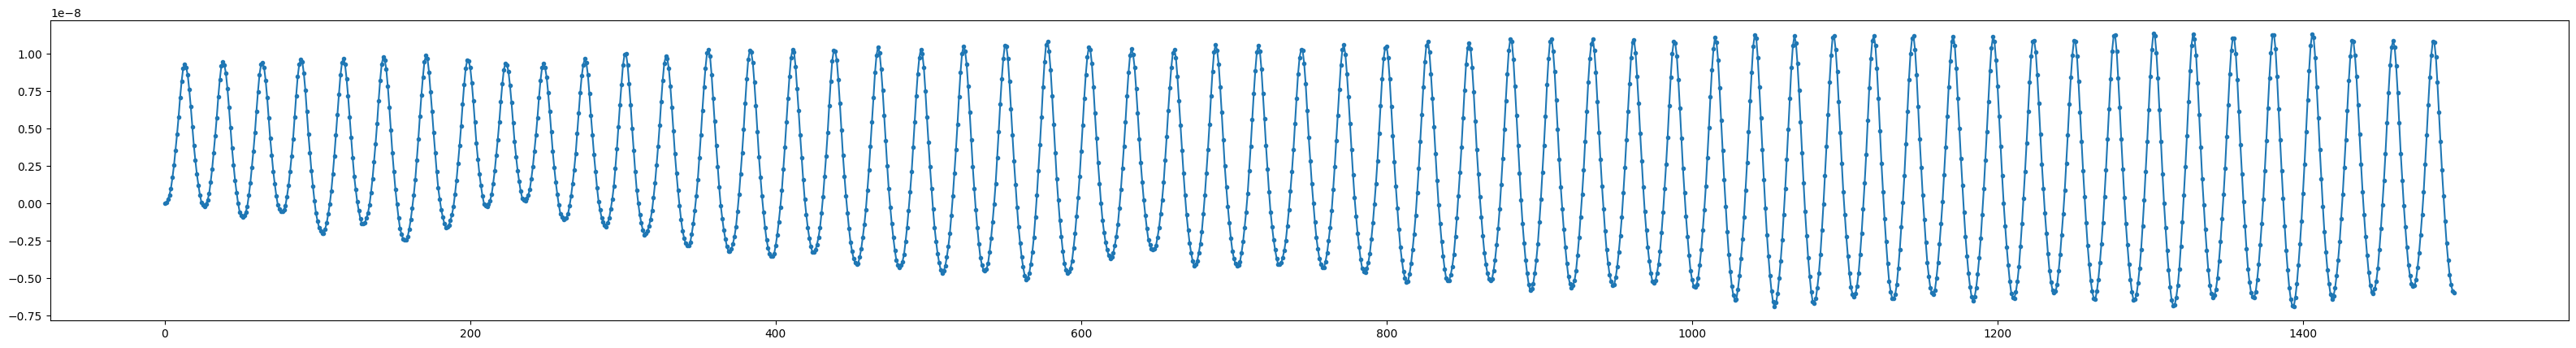

In [195]:
plt.figure().set_figwidth(40)
plt.plot(outputs[0,:], marker = '.')

## Training and testing Linear Readout layer

In [98]:
train_input = outputs[0,:].reshape((300, 5))
test_input = outputs[1,:].reshape((300, 5))
train_target = train_target.reshape((300,1))
test_target = test_target.reshape((300,1))
inputs = np.concatenate((train_input, test_input), axis = 0)

In [99]:
inputs = preprocessing.normalize(inputs)
train_input = inputs[:300, :]
test_input = inputs[300:, :]

In [100]:
def NMSE_metric(y_true, y_pred):
    nmse = keras.backend.square(y_true - y_pred)/keras.backend.square(y_true)
    return nmse 

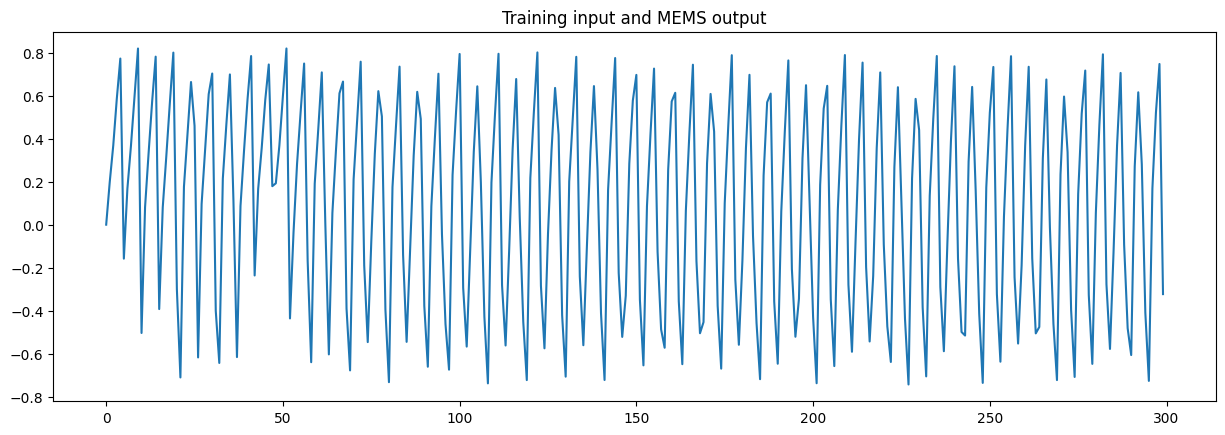

In [101]:
plt.figure().set_figwidth(15)
plt.plot(train_input[:,0])
plt.title("Training input and MEMS output")
plt.show()

In [102]:
model = keras.Sequential([
    layers.Dense(1, input_shape = (5,), activation = 'linear'),
])
model.compile(optimizer = 'Adam', loss = 'mse', metrics = [NMSE_metric])
model.fit(train_input, train_target, epochs = 1000, batch_size = 32, verbose = True)


Epoch 1/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2263 - NMSE_metric: 2.1748
Epoch 2/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.2100 - NMSE_metric: 2.0027
Epoch 3/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1949 - NMSE_metric: 1.8405
Epoch 4/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1808 - NMSE_metric: 1.6949
Epoch 5/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1680 - NMSE_metric: 1.5589
Epoch 6/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.1567 - NMSE_metric: 1.4382
Epoch 7/1000
10/10 [==============================] - 0s 988us/step - loss: 0.1457 - NMSE_metric: 1.3254
Epoch 8/1000
10/10 [==============================] - 0s 889us/step - loss: 0.1361 - NMSE_metric: 1.2242
Epoch 9/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1271 - NMSE_metric: 1.1340
Epoch 10/1000
10/10 [==============================] - 0s 1ms/step - 

In [103]:
test_pred = model.predict(test_input)

10/10 [==============================] - 0s 908us/step


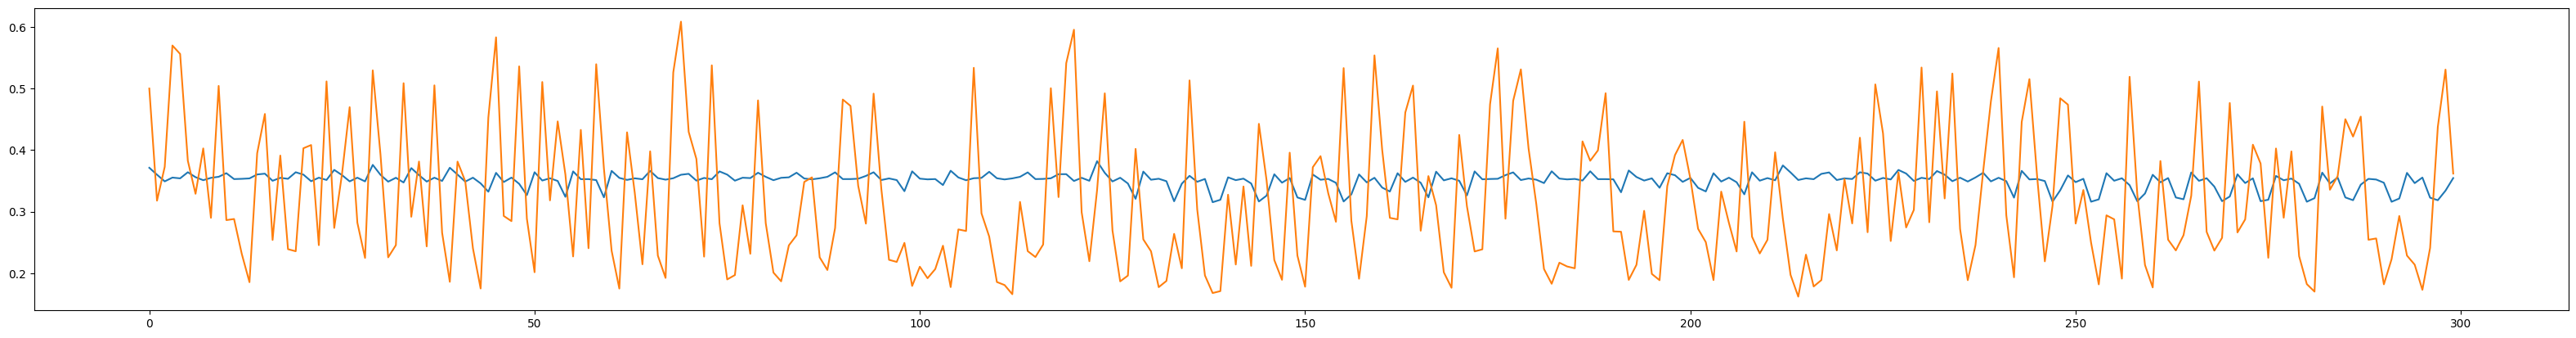

In [197]:
plt.figure().set_figwidth(40)
plt.plot(test_pred)
plt.plot(test_target)

# Defining MEMS class

In [198]:
class MEMSDevice:
    def __init__(self, parameters):
        self.sine_freq = parameters['sine_freq']
        self.num_features = parameters['num_features']
        self.separation_time = 1/self.sine_freq
        self.a = parameters['a']
        self.b = parameters['b']
        self.c = parameters['c']
        self.alpha = parameters['alpha']
        self.total_samples = 1000*self.num_features

        self.x0 = 0.0
        self.v0 = 0.0
        self.initial_state = [self.x0, self.v0]

        self.time_points = np.linspace(0, self.num_features*self.separation_time, self.total_samples)
        self.sine_wave = np.sin(2*np.pi*self.sine_freq*self.time_points)
        self.mask_values = np.asarray([0.70, 0.45, 0.45, 0.70, 0.70])
        self.mask_d = np.tile(self.mask_values, (self.num_features, 1))
        self.mask_c = np.repeat(self.mask_d, 1000/5)
        
    def F(self, t):
        sample_idx = int(t / (self.separation_time * self.num_features) * self.total_samples)
        return self.alpha * (0.4 * self.masked_input[sample_idx % self.total_samples]) ** 2


    def ODE(self, xv, t):
        x, v = xv
        dxdt = v
        dvdt = -self.a*v - self.b*x - self.c*x**3 + self.F(t)
        return [dxdt, dvdt]

    def compute(self, input):
        start = tm.time()
        self.input_c = np.repeat(input*0.15 + 0.6, 1000)
        self.modulated_input = self.input_c*self.sine_wave
        self.masked_input = self.modulated_input*self.mask_c
        self.output = np.array(odeint(self.ODE, self.initial_state, self.time_points, args = ())[:,0])
        self.output = [self.output[i] for i in range(len(self.output)) if i%200 == 0]
        end = tm.time()
        print(f"Solved in {end-start} seconds")
        return self.output
        
        
    
    

In [203]:
parameters = {
'a' : 70,
'b' : 2.088e12,
'c' : 2.9e26,
'alpha' : 460,
'sine_freq' : 115e3,
'num_features' : 300,
}
device = MEMSDevice(parameters)

Solved in 0.23611855506896973 seconds


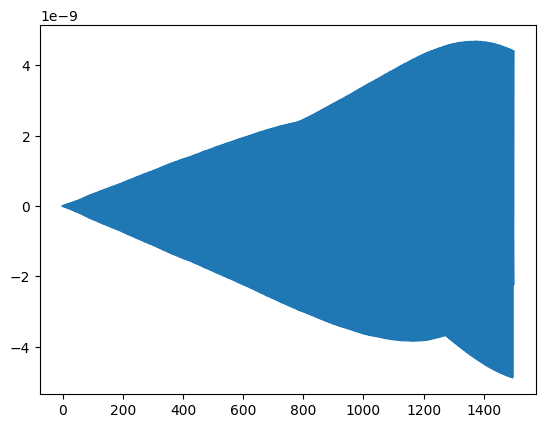

In [204]:
input = np.random.rand(300)
input = np.clip(input, 0, 1)
# Compute the response of the MEMS device
output = device.compute(input)

plt.plot(device.output)
